### (1). Setting up the environment

In [1]:
# Import required packages
import concurrent.futures
import ee
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling,transform_bounds,transform_geom
from rasterio.merge import merge
from rasterio.transform import Affine
import restee as ree
from scipy.signal import medfilt2d
import shutil
from skimage.filters import threshold_otsu
from tqdm import tqdm
from zipfile import ZipFile

In [2]:
# import required helper functions
%run Helper_Functions.ipynb

### (2). Creating IO folder structure

In [3]:
# Define the image path for post disaster ALOS2 Scene
image_path = '../../Data/16c19b23-9422-4316-a261-d70575dbee32.zip'

# Define the output folder path
output_directory = '../../Results'

Below cell will create a set of directories to save temporary data and results. the final output (flood layer) can be found in the **A_flood_product** folder.

In [4]:
# Creation of directories
dir_list = ['temp_tiles','temp_pwater_msk','temp_slope_msk','temp_masked_tiles','temp_thresh_tiles','A_flood_product']

if not os.path.exists(output_directory):
    os.makedirs(output_directory)    
for directory in dir_list:
    if not os.path.exists(os.path.join(output_directory,directory)):
        os.makedirs(os.path.join(output_directory,directory))

### (3). Exploring the ALOS2 L2.1 data

In [5]:
# ALOS2 level 2.1 data extraction
with ZipFile(image_path, 'r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for file_name in listOfFileNames:
        if file_name.endswith('.tif'):
            zipObj.extract(file_name,output_directory)

In [6]:
# Listing the extracted data
img_list = glob.glob(os.path.join(output_directory,'*.tif'))
img_list

['../../Results/IMG-HH-ALOS2453343350-221015-WBDR2.1GUD.tif',
 '../../Results/IMG-HV-ALOS2453343350-221015-WBDR2.1GUD.tif']

Finding the Correspoding UTM projection of the ALOS2 scences

In [7]:
# Selecting one of extracted images to find the UTM projection
utm_epsg = utm_finder(img_list[1])
utm_epsg

'EPSG:32647'

### (4). Radiometric calibration and speckle reduction

Resampling ALOS2 scenes to desired pixel size

In [8]:
# Resampling to 30m resolution
# Oulput name can be chosen based on the polarization.In this case it is HH and HV.
# HH polarization
resample(img_list[0],30,output_directory,'hh_resample.tif')
# HV polarization
resample(img_list[1],30,output_directory,'hv_resample.tif')

Below cell will perform the radiometric calibration (DN->SigmaNaught) and speckle reduction. Finally, data will be projected to the correspoding UTM projection.

In [9]:
# UTM code was found in above section
# HH polarization
calibration(os.path.join(output_directory,'hh_resample.tif'),utm_epsg,output_directory,'hh_calib.tif')
# HV polarization
calibration(os.path.join(output_directory,'hv_resample.tif'),utm_epsg,output_directory,'hv_calib.tif')

In [10]:
#For all the process above, it will take <3 minutes. (16GB ram,4 cpu cores)

### (5). Raster tiling 

In this section calibrated rasters will be divided into 512*512 tiles.

In [11]:
# HH polarization
tile512(os.path.join(output_directory,'hh_calib.tif'),os.path.join(output_directory,'temp_tiles'),'hh')

# HV polarization
tile512(os.path.join(output_directory,'hv_calib.tif'),os.path.join(output_directory,'temp_tiles'),'hv')

All the process hereafter are based on the HH and HV calibrated raster tiles

In [12]:
#remove all the previous temporary results in tif format
for file in glob.glob(os.path.join(output_directory,'*.tif')):
    os.remove(file)   

Below cell will create a dataframe, which stores all the raster tile paths.

In [13]:
df = pd.DataFrame(data =[],columns=['id','HH','HV'])
df['HH'] = sorted(glob.glob(os.path.join(output_directory,'temp_tiles','*hh.tif')))
df['HV'] = sorted(glob.glob(os.path.join(output_directory,'temp_tiles','*hv.tif')))
df['id'] = df.index+1

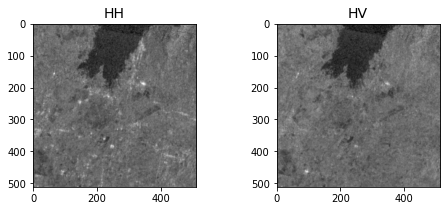

In [14]:
# Plotting random HH and HV tiles
# Run len(df)-1 to get valid random id range
random_id = 101
f, ax = plt.subplots(1, 2, figsize=(8, 3))
src_hh = rasterio.open(df['HH'][random_id])
src_hv = rasterio.open(df['HV'][random_id])
ax[0].imshow(src_hh.read(1),cmap='gray')
ax[0].set_title("HH", fontsize=14)
ax[1].imshow(src_hv.read(1),cmap='gray')
ax[1].set_title("HV", fontsize=14)
src_hh.close()
src_hv.close()
plt.show()

### (6). Google Earth Engine integration

In this section, additional data will be downloaded from gooogle earth engine for the corresponding calibrated raster tiles. Additional data include **permanent water masks** from **JRC Surface Water** data, and **slope masks** from **SRTM Dem** data. In order to run below cells, user need to have a google earth engine acount.

In [15]:
# Provide cloud project id
PROJECTID = '******'

In [ ]:
from google.auth.transport.requests import AuthorizedSession
ee.Authenticate() 
session = AuthorizedSession(ee.data.get_persistent_credentials())

In [17]:
# Creating a restee session
class EESessionContainer(ree.EESession):
    def __init__(self, project, session):
        self._PROJECT = project
        self._SESSION = session

# Create an EESesssion object with the correct permissions
ee_session = EESessionContainer(PROJECTID, session)

# Authenticate EE with the session credentials
ee.Initialize(ee_session.session.credentials, project=PROJECTID)

In [18]:
# Creating a permanent water mask from JRC surface water product
jrc_occ = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')
jrc_occ = jrc_occ.rename('pwater_mask')
pwater_mask = jrc_occ.select('pwater_mask').gt(90).selfMask()

# Creating slope mask from SRTM dem data
elevation = ee.Image('CGIAR/SRTM90_V4').select('elevation')
slope = ee.Terrain.slope(elevation)
# Masking out areas with slope > 5 
slope_mask = slope.lt(5).selfMask().rename('slope_mask')

Downloading the GEE tiles to local folders

In [19]:
# You can select either HH or HV raster tiles to request data from GEE.
# In this session HH polarization is used

In [20]:
tile_list = list(df['HH'])

In [21]:
with tqdm(total=len(tile_list),position=0, leave=True, desc="GEE data request progress: JRC Water Mask") as pbar:     
    with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor: 
        # Start the load operations and mark each future with its chip        
        future_to_chip = {executor.submit(restgee_data,chip,pwater_mask, 'pwater_mask', os.path.join(output_directory,'temp_pwater_msk')): chip for chip in tile_list}          
        for future in concurrent.futures.as_completed(future_to_chip):
            chip = future_to_chip[future]
            pbar.update(n=1)

GEE data request progress: JRC Water Mask: 100%|██████████| 756/756 [00:37<00:00, 20.15it/s]


In [22]:
with tqdm(total=len(tile_list),position=0, leave=True, desc="GEE data request progress: NASA SRTM Slope Mask") as pbar:      
    with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor: 
        # Start the load operations and mark each future with its chip        
        future_to_chip = {executor.submit(restgee_data,chip,slope_mask, 'slope_mask',os.path.join(output_directory,'temp_slope_msk')): chip for chip in tile_list}          
        for future in concurrent.futures.as_completed(future_to_chip):
            chip = future_to_chip[future]
            pbar.update(n=1)

GEE data request progress: NASA SRTM Slope Mask: 100%|██████████| 756/756 [00:30<00:00, 24.40it/s]


In [23]:
# Updating additional data paths in the dataframe
df['pwater_msk'] = sorted(glob.glob(os.path.join(output_directory,'temp_pwater_msk','*')))
df['slope_msk'] = sorted(glob.glob(os.path.join(output_directory,'temp_slope_msk','*')))

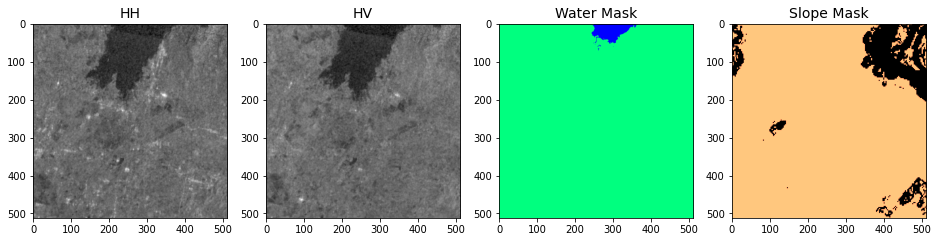

In [24]:
# Plotting hh,hv and raster masks
random_id = 101
f, ax = plt.subplots(1, 4, figsize=(16, 6))
src_hh = rasterio.open(df['HH'][random_id])
src_hv = rasterio.open(df['HV'][random_id])
src_slp_msk = rasterio.open(df['slope_msk'][random_id])
src_wat_msk = rasterio.open(df['pwater_msk'][random_id])

ax[0].imshow(src_hh.read(1),cmap='gray')
ax[0].set_title("HH", fontsize=14)
ax[1].imshow(src_hv.read(1),cmap='gray')
ax[1].set_title("HV", fontsize=14)
ax[2].imshow(src_wat_msk.read(1),cmap='winter_r')
ax[2].set_title("Water Mask", fontsize=14)
ax[3].imshow(src_slp_msk.read(1),cmap='copper')
ax[3].set_title("Slope Mask", fontsize=14)
src_hh.close()
src_hv.close()
src_slp_msk.close()
src_wat_msk.close()
plt.show()

### (7). Masking calibrated raster tiles

Masking out the calibrated raster tiles using created masks based on GEE data

In [25]:
# HH polarization
for i in tqdm(range(len(df['HH'])), desc="Data Masking Progress" ):
    pwater_slope_masking(df['HH'][i],df['pwater_msk'][i],df['slope_msk'][i],os.path.join(output_directory,'temp_masked_tiles'))

Data Masking Progress: 100%|██████████| 756/756 [00:23<00:00, 31.59it/s]


In [26]:
# HV polarization
for i in tqdm(range(len(df['HV'])), desc="Data Masking Progress" ):
    pwater_slope_masking(df['HV'][i],df['pwater_msk'][i],df['slope_msk'][i],os.path.join(output_directory,'temp_masked_tiles'))

Data Masking Progress: 100%|██████████| 756/756 [00:25<00:00, 29.17it/s]


In [27]:
# Updating masked tile paths in the dataframe 
df['masked_hh'] = sorted(glob.glob(os.path.join(output_directory,'temp_masked_tiles','*hh_masked.tif')))
df['masked_hv'] = sorted(glob.glob(os.path.join(output_directory,'temp_masked_tiles','*hv_masked.tif')))

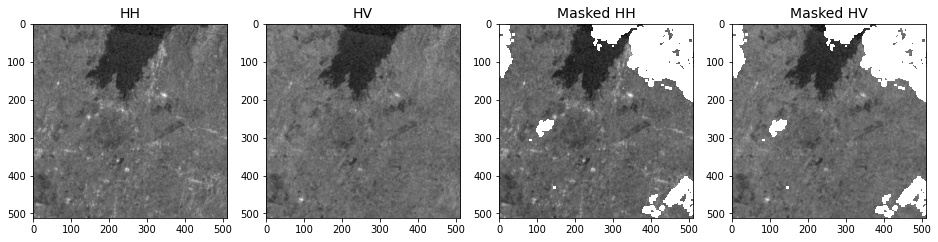

In [28]:
# 0-755
random_id = 101

f, ax = plt.subplots(1, 4, figsize=(16, 6))
src_hh = rasterio.open(df['HH'][random_id])
src_hv = rasterio.open(df['HV'][random_id])
src_msk_hh = rasterio.open(df['masked_hh'][random_id])
src_msk_hv = rasterio.open(df['masked_hv'][random_id])

ax[0].imshow(src_hh.read(1),cmap='gray')
ax[0].set_title("HH", fontsize=14)
ax[1].imshow(src_hv.read(1),cmap='gray')
ax[1].set_title("HV", fontsize=14)
ax[2].imshow(src_msk_hh.read(1),cmap='gray')
ax[2].set_title("Masked HH", fontsize=14)
ax[3].imshow(src_msk_hv.read(1),cmap='gray')
ax[3].set_title("Masked HV", fontsize=14)
src_hh.close()
src_hv.close()
src_msk_hh.close()
src_msk_hv.close()

plt.show()

### (8). Tile statistics calculation

Assuming all values in each tile lie in a Normal Distribution, 95th percentile (~2 STD) is calulated for each masked HH and HV tile. Nan value percentage of each tile is also calculated in this section.

In [29]:
import warnings
warnings.filterwarnings('ignore')

with tqdm(total=len(df),position=0, leave=True, desc="Calculating statistics for HH and HV tiles") as pbar:
    for index, row in df.iterrows():
        src1 = rasterio.open(row['masked_hh'])
        arr_1 = src1.read(1)
        src2 = rasterio.open(row['masked_hv'])
        arr_2 = src2.read(1)
    
        #calculations
        hh_mean = np.nanmean(arr_1)
        hv_mean = np.nanmean(arr_2)   
        hh_std_2nd = 2*(np.nanstd(arr_1))
        hv_std_2nd = 2*(np.nanstd(arr_2))  
        
        df.loc[index,'hh_2ndSTD'] = 2*(np.nanstd(arr_1))
        df.loc[index,'hv_2ndSTD'] = 2*(np.nanstd(arr_2))
        # geting valid pixel count percentage wrt nan value count
        df.loc[index,'val_percent'] = np.count_nonzero(~np.isnan(arr_1))*100 /arr_1.size
        
        src1.close()
        src2.close()  
        pbar.update(n=1) 

Calculating statistics for HH and HV tiles: 100%|██████████| 756/756 [00:22<00:00, 34.12it/s]


In [30]:
# Removing tiles (from the stat calculations), which has nan values more than 50% of whole pixel count of a tile
df_refined = df[df.val_percent != 0.0]
df_refined = df.loc[df['val_percent']>50]

Below cell will calculate the OTSU threshold for each masked hh and hv tile 

In [31]:
for index, row in df_refined.iterrows():
    src = rasterio.open(row['masked_hh'])
    band = src.read(1)
    band_filtered = band[~np.isnan(band)]
    otsu = threshold_otsu(band_filtered)
    df_refined.loc[index,'otsu_hh'] = otsu
    src.close()
    
for index, row in df_refined.iterrows():
    src = rasterio.open(row['masked_hv'])
    band = src.read(1)
    band_filtered = band[~np.isnan(band)]
    otsu = threshold_otsu(band_filtered)
    df_refined.loc[index,'otsu_hv'] = otsu
    src.close()   

In this part, all the tiles, which has highest 2nd STD values will be selected for futher analysis. This helps to identify tiles with water and non water areas providing a good destribution of sigma naught values.

In [32]:
# Selecting firest 20 tiles based on the 2nd STD value
# Filtering on masked HH tiles
df_refined_hh = df_refined.sort_values(by=['hh_2ndSTD'],ascending=False).head(20)
# Filtering on masked HH tiles
df_refined_hv = df_refined.sort_values(by=['hv_2ndSTD'],ascending=False).head(20)

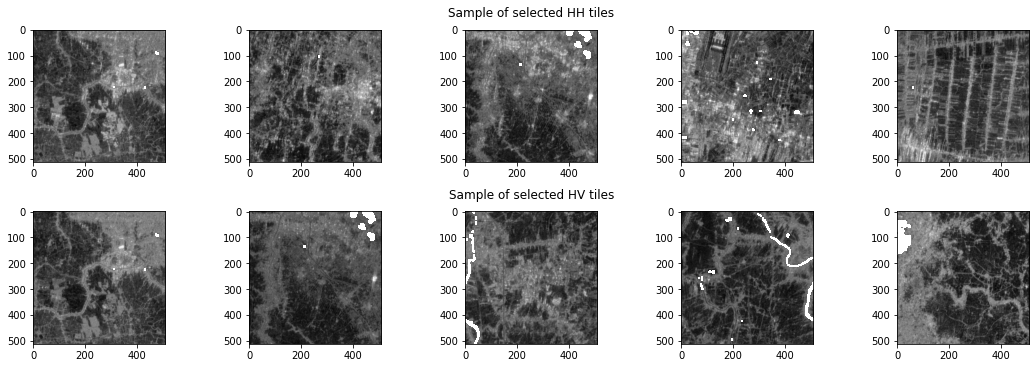

In [33]:
# Plotting sellected HH and HV tiles for reference
fig = plt.figure(constrained_layout=True,figsize=(15,5))

subfig_titles = ['Sample of selected HH tiles','Sample of selected HV tiles']

img_list = np.array([df_refined_hh['masked_hh'][0:5],df_refined_hv['masked_hv'][0:5]])
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfig_titles[row])
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=5)
    for col, ax in enumerate(axs):
        src = rasterio.open(img_list[row][col])
        ax.imshow(src.read(1),cmap='gray')             
        src.close()

#plt.savefig('../../Results/df_refined_hv.png')

In this section , OTSU thresholds of selected tiles will be filtered by IQR method (to remove outliers) and calculated mean OTSU threshold values for HH and HV polarizations.

In [34]:
otsu_mean_thresh_hh= iqr_mean(df_refined_hh['otsu_hh'])

otsu_mean_thresh_hv= iqr_mean(df_refined_hv['otsu_hv'])

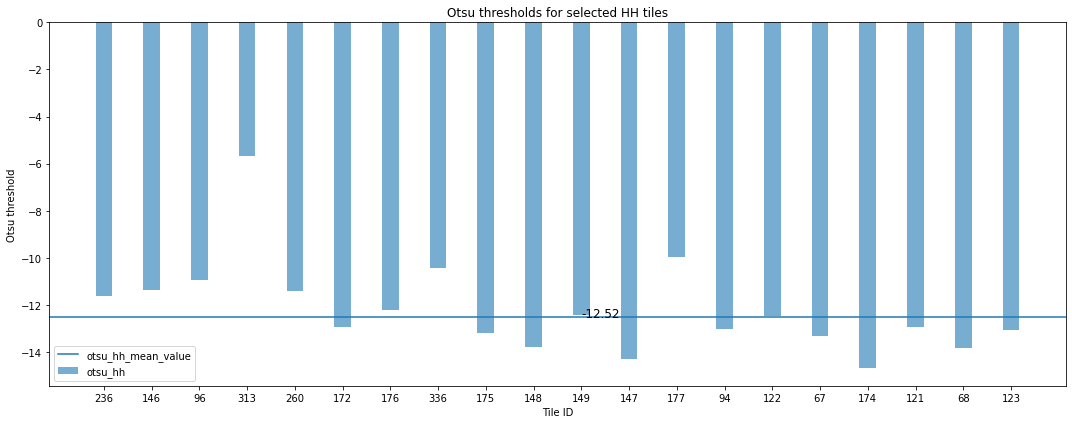

In [35]:
# Plotting selected HH tiles vs calculated OTSU threshold values
fig, ax = plt.subplots(figsize=(15, 6))
tile_id = df_refined_hh['id'].astype(str)
width = 0.35

x = np.arange(len(tile_id))
plt.axhline(y=otsu_mean_thresh_hh, color='C0', linestyle='-',label="otsu_hh_mean_value")
rect = ax.bar(x, df_refined_hh['otsu_hh'], width, label='otsu_hh',color='C0', alpha=0.6)

ax.set_ylabel('Otsu threshold')
ax.set_xlabel('Tile ID')
ax.set_title('Otsu thresholds for selected HH tiles')
ax.set_xticks(x, tile_id)
ax.legend()

plt.text(x[int(len(tile_id)/2)], otsu_mean_thresh_hh, str(otsu_mean_thresh_hh), fontsize=12)
fig.tight_layout()
plt.show()

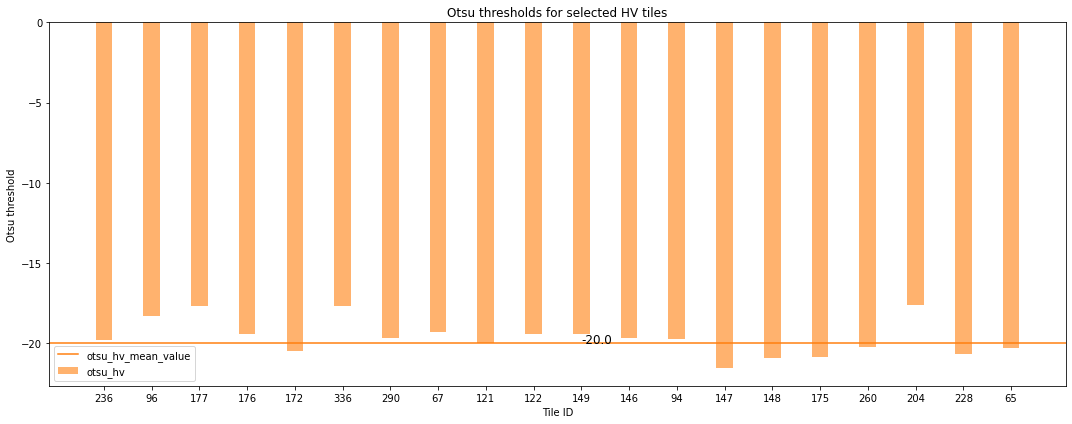

In [36]:
# Plotting selected HV tiles vs calculated OTSU threshold values
fig, ax = plt.subplots(figsize=(15, 6))
tile_id = df_refined_hv['id'].astype(str)
width = 0.35

x = np.arange(len(tile_id))
plt.axhline(y=otsu_mean_thresh_hv, color='C1', linestyle='-',label="otsu_hv_mean_value")
rect = ax.bar(x, df_refined_hv['otsu_hv'], width, label='otsu_hv',color='C1', alpha=0.6)

ax.set_ylabel('Otsu threshold')
ax.set_xlabel('Tile ID')
ax.set_title('Otsu thresholds for selected HV tiles')
ax.set_xticks(x, tile_id)
ax.legend()

plt.text(x[int(len(tile_id)/2)], otsu_mean_thresh_hv, str(otsu_mean_thresh_hv), fontsize=12)
fig.tight_layout()
plt.show()

### (9). Generation of flood layers

Two mean otsu threshold values calculated for each polarization ealier will be used to create two flood layers. In this process, all the binary rasters will be filtered by a median filter before writing to disk.

In [37]:
# Creating of HH polarization based binary rasters
bin_threshoding(df['masked_hh'],os.path.join(output_directory,'temp_thresh_tiles'),otsu_mean_thresh_hh)

Binary thresholding progress: 100%|██████████| 756/756 [00:17<00:00, 42.50it/s]


In [38]:
# Creating of HV polarization based binary rasters
bin_threshoding(df['masked_hv'],os.path.join(output_directory,'temp_thresh_tiles'),otsu_mean_thresh_hv)

Binary thresholding progress: 100%|██████████| 756/756 [00:17<00:00, 43.89it/s]


In [39]:
# Updating dataframe with binary raster paths
df['bin_hh'] = sorted(glob.glob(os.path.join(output_directory,'temp_thresh_tiles','*hh*.tif')))
df['bin_hv'] = sorted(glob.glob(os.path.join(output_directory,'temp_thresh_tiles','*hv*.tif')))

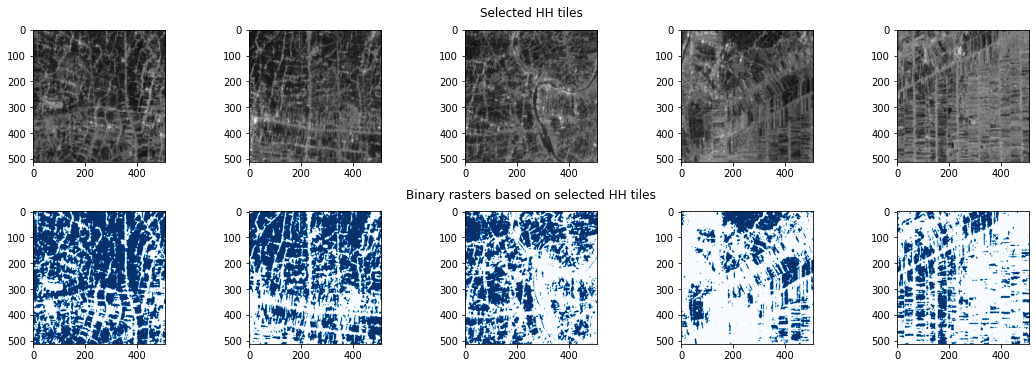

In [40]:
# Plotting HH tiles and binary rasters (flood)
fig = plt.figure(constrained_layout=True,figsize=(15,5))
subfig_titles = ['Selected HH tiles','Binary rasters based on selected HH tiles']
color_map = ['gray','Blues']

img_list = np.array([df['HH'][200:205],df['bin_hh'][200:205]])
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfig_titles[row])
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=5)
    for col, ax in enumerate(axs):
        src = rasterio.open(img_list[row][col])
        ax.imshow(src.read(1),cmap=color_map[row])             
        src.close()

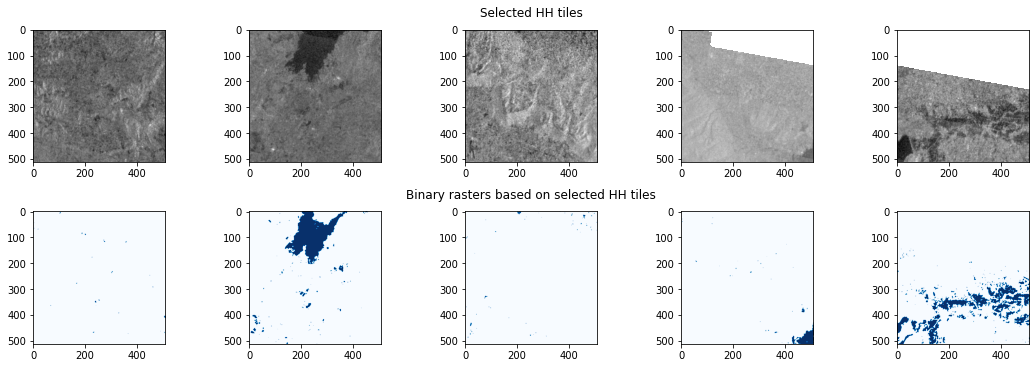

In [41]:
# Plotting HV tiles and binary rasters (flood)
fig = plt.figure(constrained_layout=True,figsize=(15,5))
subfig_titles = ['Selected HH tiles','Binary rasters based on selected HH tiles']
color_map = ['gray','Blues']

img_list = np.array([df['HV'][100:105],df['bin_hv'][100:105]])
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfig_titles[row])
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=5)
    for col, ax in enumerate(axs):
        src = rasterio.open(img_list[row][col])
        ax.imshow(src.read(1),cmap=color_map[row])             
        src.close()

Mosaic Binary Threshold raster tiles in to flood layers

In [42]:
# Flood layer based on HH tiles
mosaic_rastiles(list(df['bin_hh']),os.path.join(output_directory,'A_flood_product'),'Flood_Layer_hh.tif')

# Flood layer based on HV tiles
mosaic_rastiles(list(df['bin_hv']),os.path.join(output_directory,'A_flood_product'),'Flood_Layer_hv.tif')

Removing temporary folders

In [43]:
for dirc in glob.glob(os.path.join(output_directory,'temp*')):
    shutil.rmtree(dirc)